In [2]:
import random
import librosa
import librosa.display 
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

%matplotlib inline

## 0.5. Creating functions

In [3]:
def speech_file(room, noise, filename = ''):
    if len(filename) == 0:
        # randomly choose audio file for room, noise, specs
        path = '{}/distant-16k/speech/'.format(dat_dir)+room+'/'+noise+'/'
        sp = random.choice([f for f in os.listdir(path) if f.startswith('sp')])
        path = path+sp+'/'
        filename = random.choice(os.listdir(path))
    else:
        room = filename[17:20] 
        noise = filename[21:25]
        path = '{}/distant-16k/speech/'.format(dat_dir)+room+'/'+noise+'/'+filename[26:filename.find('-ch')]+'/'
    x, sr = librosa.load(path+filename)
    return x, sr, path+filename #[filename.find('sp'):filename.find('-mc')]

In [4]:
def source_file(noisy_spch):
    speaker = noisy_spch[noisy_spch.find('-sp')+1:noisy_spch.find('-ch')]
    scr_file = '{}/source-16k/'.format(dat_dir)+speaker+'/'+'Lab41-SRI-VOiCES-src'+noisy_spch[noisy_spch.find('-sp'):noisy_spch.find('-mc')]+'.wav'
    x, sr = librosa.load(scr_file)
    return x, sr, scr_file

In [5]:
def file_list(noise, deg = 90, room = 'all', mics =['all']):
    # ------------ check function input is valid -----------
    #noise
    assert noise in ['none', 'babb', 'musi', 'tele'], 'not a valid noise type: %r'% noise
    # deg
    assert type(deg) is int, 'deg not an int: %r' % deg
    assert 0 <= deg <= 180, 'deg is out of range: %r' % deg
    # room option
    assert room in ['rm1', 'rm2', 'all'], 'not a valid room: %r' % room
    # mic options
    valid_mics = ['0'+str(f) for f in np.arange(9)+1]+[str(f) for f in np.arange(3)+10]
    if len(mics) == 1:
        assert mics[0] in ['stu', 'lav', 'all'], 'invalid mic type: %r ' %mics[0]
    else:
        for mic in mics:
            assert mic in valid_mics, 'invalid mic Id: %r ' %mic
        
    # ----------------- define parameters ------------------
    if deg < 100:
        if deg == 0: 
            degstr ='000'
        else:
            degstr = '0'+str(deg)       
    else:
        degstr = str(deg)
    if room == 'all':
        bsdir = '{}/distant-16k/speech/*/'.format(dat_dir)
    else: 
        bsdir = '{}/distant-16k/speech/'.format(dat_dir)+room+'/'
    
    bsdir = bsdir+noise+'/*/'
    dirs = glob(bsdir)
           
    srchStr = 'dg'+degstr+'.wav'
    spkr = []
    if mics[0] != 'all':
        if len(mics) == 1:
            srchStr = '*'+mics[0]+'*'+srchStr
            files = []
            for drctr in dirs:
                file_srch = [drctr+f for f in fnmatch.filter(os.listdir(drctr), srchStr)]
                files = files + file_srch
                if len(file_srch) > 0:
                    spkr.append(drctr[drctr[:-1].rfind('/')+3:-1] )
        else:
            files = []
            for drctr in dirs:
                for mic in mics:
                    srchStr_m = '*mc'+mic+'*'+srchStr
                    file_srch = [drctr+f for f in fnmatch.filter(os.listdir(drctr), srchStr_m)]
                    files = files + file_srch
                    if len(file_srch) > 0:
                        spkr.append(drctr[drctr[:-1].rfind('/')+3:-1] )
    return files, set(spkr)

In [6]:
def get_transcript(filename, df):
    file = filename[filename.rfind('/')+1: -4]
    #return df['trnscrpt'].loc[df.fileName == file].trnscrpt.tolist()[0][1:]
    return df['trnscrpt'].loc[df.fileName == file].values[0]

In [ ]:
def read_wav(filename):
    y1, sample_rate1 = librosa.load(sour_lst[1])
    source_time = librosa.get_duration(y1)

# 1. Reading Data / Creating dataframe 

In [7]:
# Paths to folders
dat_dir = './data/VOiCES_dev'
refs_dir = './data/VOiCES_refs'

In [8]:
spkGendr = pd.read_csv('{}/Lab41-SRI-VOiCES-speaker-gender-dataset.tbl'.format(refs_dir), sep='\s+')
trascrpt = pd.read_csv('{}/Lab41-SRI-VOiCES.refs'.format(refs_dir), sep=',',header=None, names=['fileName', 'trnscrpt'])

In [18]:
voice_dat = "./data/VOiCES"
#dist_lst_rm1 = glob.glob("{}/distant-16k/distractors/rm1/*.wav".format(voice_dat))
#dist_lst_rm2 = glob.glob("{}/distant-16k/distractors/rm2/*.wav".format(voice_dat))
sour_lst = glob.glob("{}/source-16k/*/*.wav".format(voice_dat))
speaker_lst = glob.glob("{}/source-16k/*".format(voice_dat))
sour2_lst = glob.glob("./data/Hold_Out_Set/source-16k/*/*.wav")
#print(len(speaker_lst))
source_df = pd.DataFrame({'Path':sour_lst})
source_df.head()

Path
0  ./data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiC...
1  ./data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiC...
2  ./data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiC...
3  ./data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiC...
4  ./data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiC...

# 2. EDA

In [9]:
print(spkGendr.shape)
spkGendr.head()

(300, 3)


Speaker Gender          DataSet
0       32      F  train-clean-100
1       83      F  train-clean-100
2       93      F  train-clean-360
3      112      F  train-clean-360
4      115      F  train-clean-360

In [26]:
print(trascrpt.shape)

#trascrpt.loc[trascrpt['fileName'] == "Lab41-SRI-VOiCES-rm1-tele-sp7850-ch286674-sg0016-mc01-stu-clo-dg030"]
file_names = trascrpt['fileName'].values
print(trascrpt.iloc[0][[0][0]])

(378591, 2)
Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg0007-mc01-stu-clo-dg150


In [27]:
# load to specific file
#x, sr, nam = speech_file('','')
# Randomly select an audio file for a specific room and noise type
sp_x, sp_sr, sp_nam = speech_file('rm1', 'tele') 

# Let's also load the source audio for comparison
src_x, src_sr, src_nam = source_file(sp_nam)

In [28]:
print(sp_nam[sp_nam.find('Lab41-SRI-VOiCES'):])
print('Transcript:')
print(get_transcript(sp_nam, trascrpt))
ipd.Audio(sp_nam)

Lab41-SRI-VOiCES-rm1-tele-sp7976-ch110523-sg0010-mc05-stu-far-dg110.wav
Transcript:
hansel thought the roof tasted very nice and so he tore off a great piece while grethel broke a large round pane out of the window and sat down quite contentedly


In [29]:
# Play the clean source file
print(src_nam[src_nam.find('Lab41-SRI-VOiCES'):])
ipd.Audio(src_nam)

Lab41-SRI-VOiCES-src-sp7976-ch110523-sg0010.wav


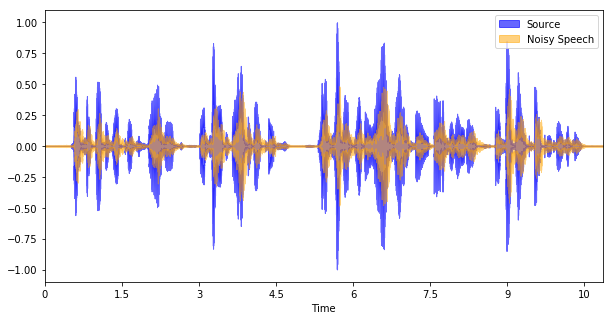

In [30]:
plt.figure(figsize = (10,5))
librosa.display.waveplot(src_x, src_sr, color = 'blue', alpha = 0.6, label = 'Source')
librosa.display.waveplot(sp_x, sr = sp_sr, alpha = 0.5, color = 'orange',label = 'Noisy Speech')
plt.legend()

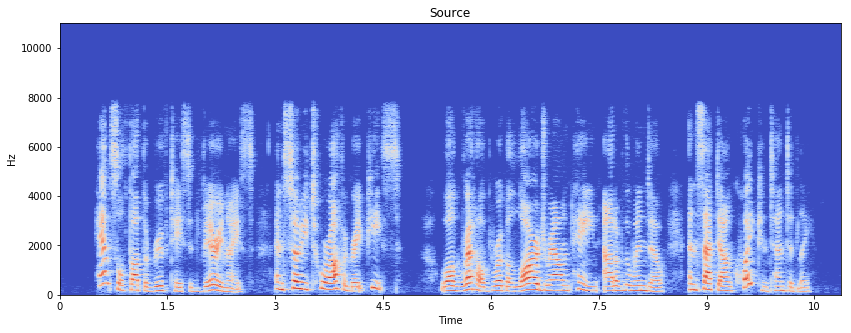

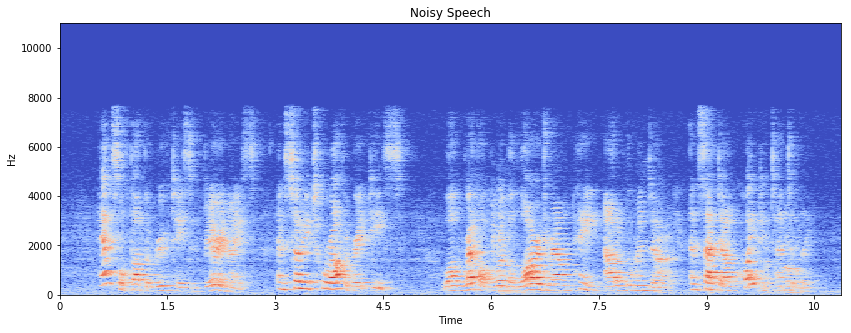

In [31]:
# source 
src_ft = librosa.stft(src_x)
src_db = librosa.amplitude_to_db(abs(src_ft))
plt.figure(figsize=(14, 5))
plt.title('Source')
librosa.display.specshow(src_db, sr=src_sr, x_axis='time', y_axis='hz')
# noisy speech
sp_ft = librosa.stft(sp_x)
sp_db = librosa.amplitude_to_db(abs(sp_ft))
plt.figure(figsize=(14, 5))
plt.title('Noisy Speech')
librosa.display.specshow(sp_db, sr=src_sr, x_axis='time', y_axis='hz')

200
2583
1320
48
48
16.40503401360544
3300.0
(361731,)
(361731,)


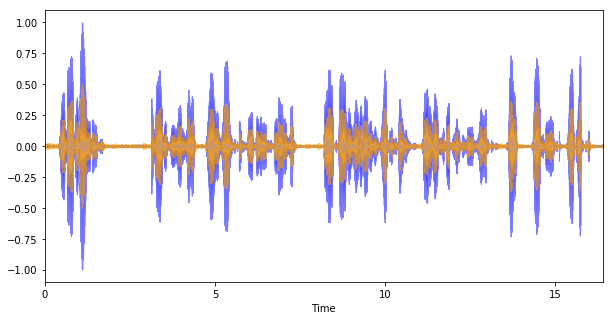

In [32]:
voice_dat = "./data/VOiCES"
dist_lst_rm1 = glob.glob("{}/distant-16k/distractors/rm1/*.wav".format(voice_dat))
dist_lst_rm2 = glob.glob("{}/distant-16k/distractors/rm2/*.wav".format(voice_dat))
sour_lst = glob.glob("{}/source-16k/*/*.wav".format(voice_dat))
speaker_lst = glob.glob("{}/source-16k/*".format(voice_dat))
sour2_lst = glob.glob("./data/Hold_Out_Set/source-16k/*/*.wav")
print(len(speaker_lst))
print(len(sour_lst))
print(len(sour2_lst))
print(len(dist_lst_rm1))
print(len(dist_lst_rm2))

y1, sample_rate1 = librosa.load(sour_lst[1])
source_time = librosa.get_duration(y1)
print(source_time)
dist_time = librosa.get_duration(filename=dist_lst_rm1[0])
print(dist_time)
y2, sample_rate2 = librosa.load(dist_lst_rm1[0],duration=source_time)
#y2 = random.choices(y2, k=len())
print(y1.shape)
print(y2.shape)
# MERGE
plt.figure(figsize = (10,5))
librosa.display.waveplot(y1,sample_rate1, alpha = 0.5, color = "blue",label = 'Speech')
librosa.display.waveplot((y1+y2[0:len(y1)])/2, sr=int((sample_rate1+sample_rate2)/2),color = 'orange', alpha = 0.6, label = ' Noisy Source')

# REPRODUCE
ipd.Audio((y1+y2[0:len(y1)])/2, rate=int((sample_rate1+sample_rate2)/2))

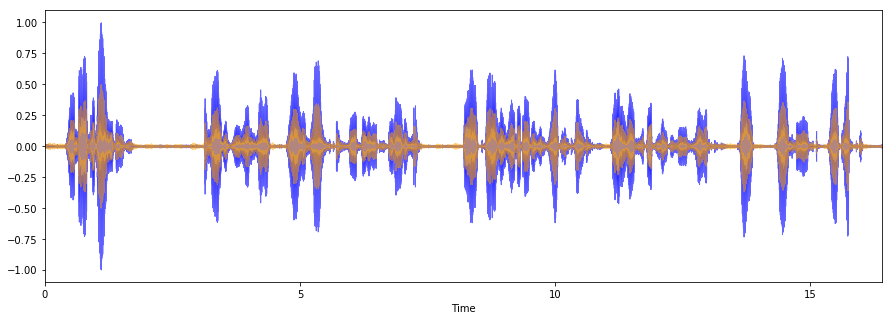

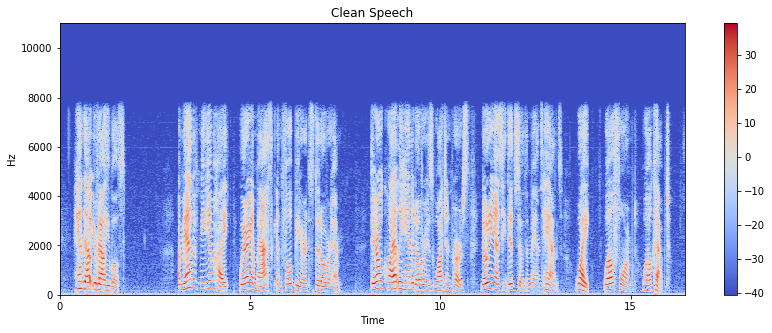

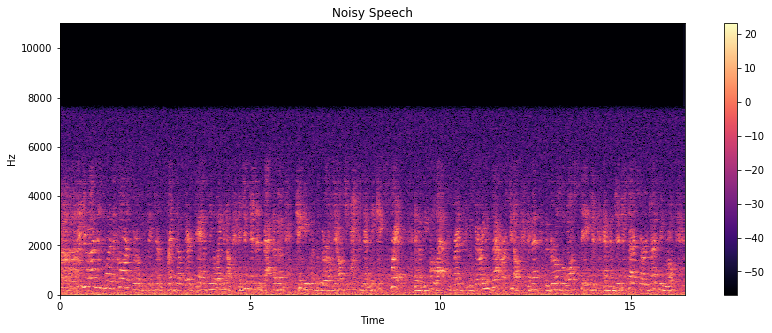

In [42]:
plt.figure(figsize = (15,5))
librosa.display.waveplot(y1,sample_rate1, color = 'blue', alpha = 0.6, label = 'Source')
librosa.display.waveplot((y1+y2[0:len(y1)])/2, sr=int((sample_rate1+sample_rate2)/2),alpha = 0.5, color = 'orange',label = 'Noisy Speech')
ipd.Audio(y1, rate=sample_rate1)

sp_ft = librosa.stft(y1)
sp_db = librosa.amplitude_to_db(abs(sp_ft))
plt.figure(figsize=(14, 5))
plt.title('Clean Speech')
librosa.display.specshow(sp_db, sr=sample_rate1, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()
sp_ft = librosa.stft(y2)
sp_db = librosa.amplitude_to_db(abs(sp_ft))
plt.figure(figsize=(14, 5))
plt.title('Noisy Speech')
librosa.display.specshow(sp_db, sr=sample_rate2, x_axis='time', y_axis='hz')
plt.colorbar()

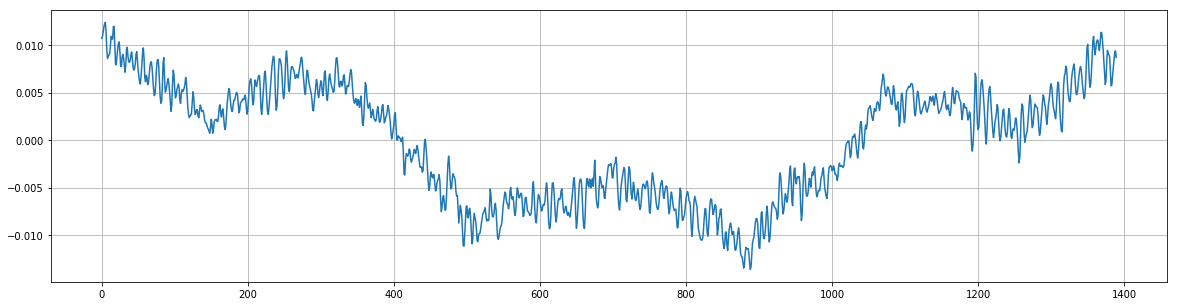

In [49]:
n0 = 10
n1 = 1400
plt.figure(figsize=(20, 5))
plt.plot(y1[n0:n1])
plt.grid()

200
2583
1320
48
48
16.40503401360544
3300.0
(361731,)
(361731,)


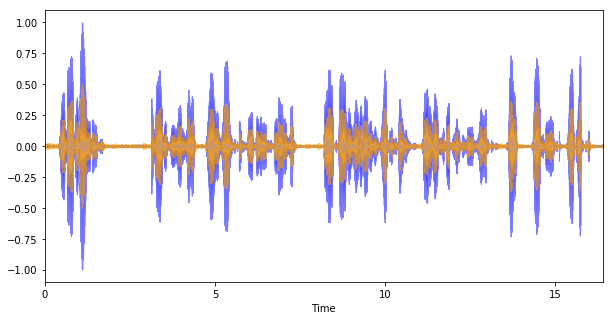